# Base Agent based on LangGraph

## chatbot with RAG

In [1]:
# 표준 라이브러리
import warnings
from typing import Annotated
from typing_extensions import TypedDict

# 환경 변수
from dotenv import load_dotenv

# 외부 라이브러리
from pinecone import Pinecone, ServerlessSpec

# LangChain 및 연동 라이브러리
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools.retriever import create_retriever_tool
from langchain_core.runnables import RunnablePassthrough, RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_docling import DoclingLoader
from langchain_docling.loader import ExportType
from langchain_pinecone import PineconeVectorStore

# 프로젝트/특수 목적 라이브러리
from langchain_teddynote import logging
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import (
    messages_to_history,
    invoke_graph,
    stream_graph,
    random_uuid,
)

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores import Qdrant
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


warnings.filterwarnings(action="ignore")

load_dotenv()

logging.langsmith("Base-agent")

/Users/sean/lagom/paper-study-agent/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LangSmith 추적을 시작합니다.
[프로젝트명]
Base-agent


In [2]:
class PaperState(TypedDict):
    title: Annotated[str, "Title"]  # 문서 이름
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [3]:
def create_retriever():
    loader = PyMuPDFLoader(
        "../data/Retrieval Augmented Generation for Knowledge Intensive NLP Tasks.pdf"
    )
    docs = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    split_documents = text_splitter.split_documents(docs)

    embeddings = OpenAIEmbeddings()

    pc = Pinecone()
    index_name = "paper"

    index_names = [index_info["name"] for index_info in pc.list_indexes()]

    if index_name not in index_names:
        pc.create_index(
            name=index_name,
            dimension=1536,  # OpenAI 임베딩 벡터 차원
            metric="dotproduct",
            spec=ServerlessSpec(cloud="aws", region="us-east-1"),
        )
        print(f"{index_name} 인덱스를 새로 생성했습니다.")
    else:
        print(
            f"{index_name} 인덱스가 이미 존재합니다. 기존 인덱스에 데이터를 추가합니다."
        )

    vectorstore = PineconeVectorStore.from_documents(
        split_documents, embeddings, index_name=index_name
    )
    print("문서가 인덱스에 추가되었습니다.")

    retriever = vectorstore.as_retriever()

    return retriever


pdf_retriever = create_retriever()

retriever_tool = create_retriever_tool(
    retriever=pdf_retriever,
    name="pdf_retriever",
    description="Search and return information about PDF file.",
)

tools = [retriever_tool]

paper 인덱스가 이미 존재합니다. 기존 인덱스에 데이터를 추가합니다.
문서가 인덱스에 추가되었습니다.


In [4]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


# Chat 노드
def chat_node(state: PaperState) -> PaperState:

    question = state["question"]
    state["messages"] = question

    title = state["title"]

    llm_tools = llm.bind_tools(tools)
    prompt = f"""제공된 문서를 참고해서 질문에 대답해줘. 
    한국말로 대답해줘.
    # 제공된 문서 이름
    {title}

    # 질문:
    {question}
    """
    answer = llm_tools.invoke(prompt)
    state["answer"] = answer

    return {"messages": [answer]}


# Retrieval 노드
def retrieval_node(state: PaperState) -> PaperState:
    question = state["question"]
    context = pdf_retriever.invoke(question)

    return {"context": [context]}


# Generation 노드
def generation_node(state: PaperState) -> PaperState:
    question = state["question"]
    context = state["context"]
    title = state["title"]
    prompt = f"""제공된 문서를 참고해서 질문에 대답해줘. 
    참고 내용의 페이지를 알려줘.
    한국말로 대답해줘.
    # 제공된 문서 이름
    {title}

    # 참고 내용
    {context}

    # 질문:
    {question}
    """
    answer = llm.invoke(prompt)

    return {"answer": [answer]}

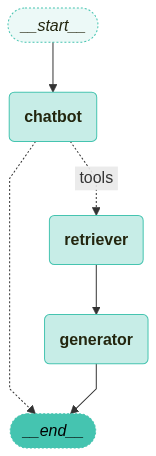

In [5]:
graph_builder = StateGraph(PaperState)

graph_builder.add_node("chatbot", chat_node)
graph_builder.add_node("retriever", retrieval_node)
graph_builder.add_node("generator", generation_node)

graph_builder.add_edge(START, "chatbot")

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "retriever",
        END: END,
    },
)

graph_builder.add_edge("retriever", "generator")
graph_builder.add_edge("generator", END)

graph = graph_builder.compile(checkpointer=MemorySaver())

visualize_graph(graph)

In [6]:
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": random_uuid()})

paper_title = "Retrieval Augmented Generation for Knowledge Intensive NLP Tasks.pdf"
question = "안녕"
inputs = PaperState(question=question, title=paper_title)

invoke_graph(graph, inputs, config)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_J5ZksFUM1ViYIP2iuMfQY967)
 Call ID: call_J5ZksFUM1ViYIP2iuMfQY967
  Args:
    query: 안녕

🔄 Node: retriever 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[Document(id='9231b7eb-7ada-45ba-a5a4-75d4924e1e64', metadata={'author': '', 'creationDate': 'D:20240410211143Z', 'creationdate': '2024-04-10T21:11:43+00:00', 'creator': 'LaTeX with hyperref', 'file_path': '../data/Attention Is All You Need.pdf', 'format': 'PDF 1.5', 'keywords': '', 'modDate': 'D:20240410211143Z', 'moddate': '2024-04-10T21:11:43+00:00', 'page': 11.0, 'producer': 'pdfTeX-1.40.25', 'source': '../data/Attention Is All You Need.pdf', 'subject': '', 'title': '', 'total_pages': 15.0, 'trapped': ''}, page_content='[37] Vinyals & Kaiser, Koo, Petrov, Sutskever, and Hinton. Grammar as a foreign language. In\nAdvances in Neural Information 

In [7]:
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": random_uuid()})

paper_title = "Retrieval Augmented Generation for Knowledge Intensive NLP Tasks.pdf"
question = "이 문서의 저자는 누구야?"
inputs = PaperState(question=question, title=paper_title)

invoke_graph(graph, inputs, config)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_eIuxhvauO59YwNud2qdsHF7b)
 Call ID: call_eIuxhvauO59YwNud2qdsHF7b
  Args:
    query: 저자

🔄 Node: retriever 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[Document(id='b777abf8-576d-4b70-981e-d27c1fd9c4c0', metadata={'author': '', 'creationDate': 'D:20210413004838Z', 'creationdate': '2021-04-13T00:48:38+00:00', 'creator': 'LaTeX with hyperref', 'file_path': '../data/Retrieval Augmented Generation for Knowledge Intensive NLP Tasks.pdf', 'format': 'PDF 1.5', 'keywords': '', 'modDate': 'D:20210413004838Z', 'moddate': '2021-04-13T00:48:38+00:00', 'page': 9.0, 'producer': 'pdfTeX-1.40.21', 'source': '../data/Retrieval Augmented Generation for Knowledge Intensive NLP Tasks.pdf', 'subject': '', 'title': '', 'total_pages': 19.0, 'trapped': ''}, page_content='Computational Linguistics (Volume 1: Long Papers

In [8]:
config = RunnableConfig(recursion_limit=5, configurable={"thread_id": random_uuid()})

paper_title = "Retrieval Augmented Generation for Knowledge Intensive NLP Tasks.pdf"
question = "'Retrieval Augmented Generation for Knowledge Intensive NLP Tasks'의 저자는 누구야?"
inputs = PaperState(question=question, title=paper_title)

invoke_graph(graph, inputs, config)


🔄 Node: chatbot 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  pdf_retriever (call_N8AleGbDKTolHcYJrwauz7An)
 Call ID: call_N8AleGbDKTolHcYJrwauz7An
  Args:
    query: Retrieval Augmented Generation for Knowledge Intensive NLP Tasks 저자

🔄 Node: retriever 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[Document(id='2ddc94fb-afc9-425e-bd25-c1cf5b9bef01', metadata={'author': '', 'creationDate': 'D:20210413004838Z', 'creationdate': '2021-04-13T00:48:38+00:00', 'creator': 'LaTeX with hyperref', 'file_path': '../data/Retrieval Augmented Generation for Knowledge Intensive NLP Tasks.pdf', 'format': 'PDF 1.5', 'keywords': '', 'modDate': 'D:20210413004838Z', 'moddate': '2021-04-13T00:48:38+00:00', 'page': 0.0, 'producer': 'pdfTeX-1.40.21', 'source': '../data/Retrieval Augmented Generation for Knowledge Intensive NLP Tasks.pdf', 'subject': '', 'title': '', 'total_pages': 19.0, 'trapped': ''